In [1]:
import sys, os
from pathlib import Path
notebook_dir = Path().resolve()
project_root = notebook_dir.parent
sys.path.insert(0, str(project_root))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

from src.neural_network import NeuralNetwork
from src.activations import Sigmoid, Linear
from src.losses import MSE
from src.optimizers import Adam, RMSprop
from src.training import train
from src.metrics import mse
from src.utils import runge, polynomial_features, scale_data, Ridge_parameters, inverse_scale_y
from src.plotting import lambda_eta_heatmap, plot_learning_curves

In [2]:
SEED = 42
np.random.seed(SEED)

N = 1000
x = np.linspace(-1, 1, N)
y_true = runge(x)
y_noise = y_true + np.random.normal(0, 0.1, N)

# Setup for Ridge Regression

In [3]:
X_poly = polynomial_features(x, p=9, intercept=False)

X_train_poly, X_test_poly, y_train, y_test = train_test_split(
    X_poly, y_noise, test_size=0.2, random_state=SEED
)
# Scale data
X_train_s, y_train_s, X_mean, X_std, y_mean = scale_data(X_train_poly, y_train)
X_test_s, y_test_s, _, _, _ = scale_data(
    X_test_poly, y_test, X_mean, X_std, y_mean
)

theta_ridge = Ridge_parameters(X_train_s, y_train_s, lam=0.01)
y_pred_ridge = X_test_s @ theta_ridge
ridge_mse = mse(y_test_s.reshape(-1, 1), y_pred_ridge.reshape(-1, 1))

## Setup for Lasso Regression

In [4]:
X_poly = polynomial_features(x, p=9, intercept=False)

X_train_poly, X_test_poly, y_train, y_test= train_test_split(
    X_poly, y_noise, test_size=0.2, random_state=SEED
)
# Scale data
X_train_s, y_train_s, X_mean, X_std, y_mean = scale_data(X_train_poly, y_train)
X_test_s, y_test_s, _, _, _ = scale_data(
    X_test_poly, y_test, X_mean, X_std, y_mean
)

lasso_model = Lasso(alpha=0.01, max_iter=10000, random_state=SEED)
lasso_model.fit(X_train_s, y_train_s.ravel())
y_pred_lasso = lasso_model.predict(X_test_s)
lasso_mse = mse(y_test_s.reshape(-1, 1), y_pred_lasso.reshape(-1, 1))

# Setup for FFNN

In [5]:
# Split into train (80%) and test (20%)
X_train_raw, X_test_raw, y_train_nn, y_test_nn = train_test_split(
    x.reshape(-1, 1), y_noise.reshape(-1, 1),
    test_size=0.2, random_state=SEED
)

# Split train (80%) into train (60%) and validation (20%)
X_train_raw, X_val_raw, y_train_nn, y_val_nn = train_test_split(
    X_train_raw, y_train_nn,
    test_size=0.25,
    random_state=SEED
)
X_train_s, y_train_s, X_mean, X_std, y_mean = scale_data(X_train_raw, y_train_nn)
X_val_s,   y_val_s,   _,      _,     _      = scale_data(X_val_raw,   y_val_nn,  X_mean, X_std, y_mean)
X_test_s,  y_test_s,  _,      _,     _      = scale_data(X_test_raw,  y_test_nn, X_mean, X_std, y_mean)

y_train_real = inverse_scale_y(y_train_s, y_mean)
y_val_real   = inverse_scale_y(y_val_s,   y_mean)
y_test_real  = inverse_scale_y(y_test_s,  y_mean)

# Stochastic Gradient Descent with RMSprop (L1/L2 Regularization)

In [6]:
eta_vals = np.logspace(-5, -1, 5)
lambda_vals = np.logspace(-5, 1, 5)
hidden_layers = [50, 50]
regularization_type_rms = "l2"

n_eta = len(eta_vals)
n_lambda = len(lambda_vals)

# Storage
models = [[None for _ in range(n_lambda)] for _ in range(n_eta)]
histories = [[None for _ in range(n_lambda)] for _ in range(n_eta)]
train_mse = np.zeros((n_eta, n_lambda))
test_mse = np.zeros((n_eta, n_lambda))
val_mse   = np.zeros((n_eta, n_lambda))

# Grid search
for i, eta in enumerate(eta_vals):
    for j, lam in enumerate(lambda_vals):
        # Create and train model
        model = NeuralNetwork(
            network_input_size=1,
            layer_output_sizes=hidden_layers + [1],
            activations=[Sigmoid(), Sigmoid(), Linear()],
            loss=MSE(),
            seed=SEED,
            lambda_reg=lam,
            reg_type= regularization_type_rms if lam > 0 else None,
        )
        
        optimizer = RMSprop(eta=eta)
        
        history = train(
            nn=model,
            X_train=X_train_s,
            y_train=y_train_s,
            X_val=X_val_s,
            y_val=y_val_s,
            optimizer=optimizer,
            epochs=1500,
            batch_size=16,
            stochastic=True,
            task='regression',
            early_stopping=False,
            patience=150,
            verbose=False,
            seed=SEED
        )
        histories[i][j] = history
        models[i][j] = model
        
        # Evaluate
        y_train_pred = inverse_scale_y(model.predict(X_train_s), y_mean)
        y_val_pred   = inverse_scale_y(model.predict(X_val_s),   y_mean)
        y_test_pred  = inverse_scale_y(model.predict(X_test_s),  y_mean)

        y_train_real = inverse_scale_y(y_train_s, y_mean)
        y_val_real   = inverse_scale_y(y_val_s,   y_mean)
        # y_test_real should already exist; if not, compute like above

        train_mse[i, j] = mse(y_train_real, y_train_pred)
        val_mse[i, j]   = mse(y_val_real,   y_val_pred)
        test_mse[i, j]  = mse(y_test_real,  y_test_pred)

# Pick best by VALIDATION
i_best, j_best = np.unravel_index(np.argmin(val_mse), val_mse.shape)
best_eta_rms    = eta_vals[i_best]
best_lambda_rms = lambda_vals[j_best]

best_history = histories[i_best][j_best]
best_train_mse_rms = train_mse[i_best, j_best]
best_val_mse_rms   = val_mse[i_best, j_best]
best_test_mse_rms  = test_mse[i_best, j_best]  

print(f"Best eta:        {best_eta_rms}")
print(f"Best lambda:     {best_lambda_rms}")
print(f"Best train MSE:  {best_train_mse_rms:.6f}")
print(f"Best val MSE:    {best_val_mse_rms:.6f}")
print(f"Best test MSE:   {best_test_mse_rms:.6f}")

# Plot the best model's learning curves (train vs validation)




Best eta:        0.01
Best lambda:     1e-05
Best train MSE:  0.009737
Best val MSE:    0.009476
Best test MSE:   0.009648


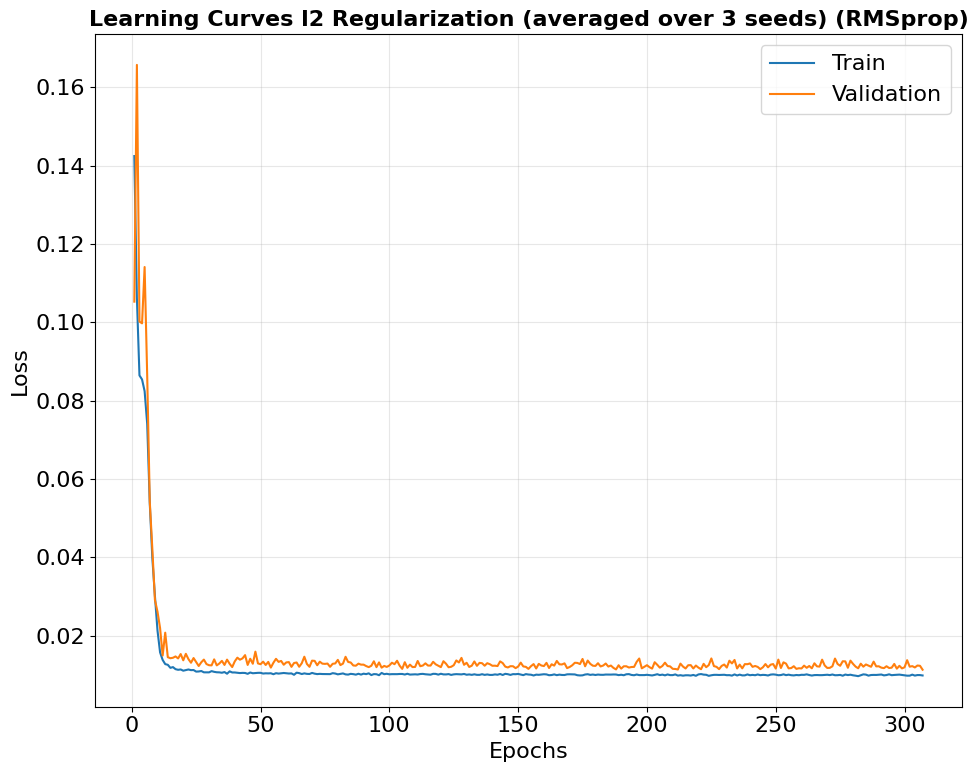

In [7]:
# --- Averaging over seeds using the fixed best hyperparameters ---
seeds = [100, 50, 12]
best_histories = []

for seed in seeds:
    model = NeuralNetwork(
        network_input_size=1,
        layer_output_sizes=hidden_layers + [1],
        activations=[Sigmoid(), Sigmoid(), Linear()],
        loss=MSE(),
        seed=seed,  # <-- use the loop seed
        lambda_reg=best_lambda_rms,
        reg_type=regularization_type_rms if best_lambda_rms > 0 else None,  # <-- use best_lambda
    )

    optimizer = RMSprop(eta=best_eta_rms)

    history = train(
        nn=model,
        X_train=X_train_s, y_train=y_train_s,
        X_val=X_val_s,     y_val=y_val_s,
        optimizer=optimizer,
        epochs=1500, batch_size=16, stochastic=True,
        task='regression',
        early_stopping=True, patience=150,
        verbose=False,
        seed=seed  # <-- use the loop seed
    )

    best_histories.append(history)

# Align (early stopping may yield different lengths)
min_len = min(len(h["train_loss"]) for h in best_histories)

train_mean = np.mean([np.array(h["train_loss"][:min_len]) for h in best_histories], axis=0)
val_mean   = np.mean([np.array(h["val_loss"][:min_len])   for h in best_histories], axis=0)

# Plot with your helper
plot_learning_curves(
    train_loss=train_mean,
    val_loss=val_mean,
    epochs=np.arange(1, min_len + 1),
    title=f"Learning Curves {regularization_type_rms} Regularization (averaged over 3 seeds) (RMSprop)"
)
plt.savefig(f"figs/learning_curve_{regularization_type_rms}_rms.pdf")

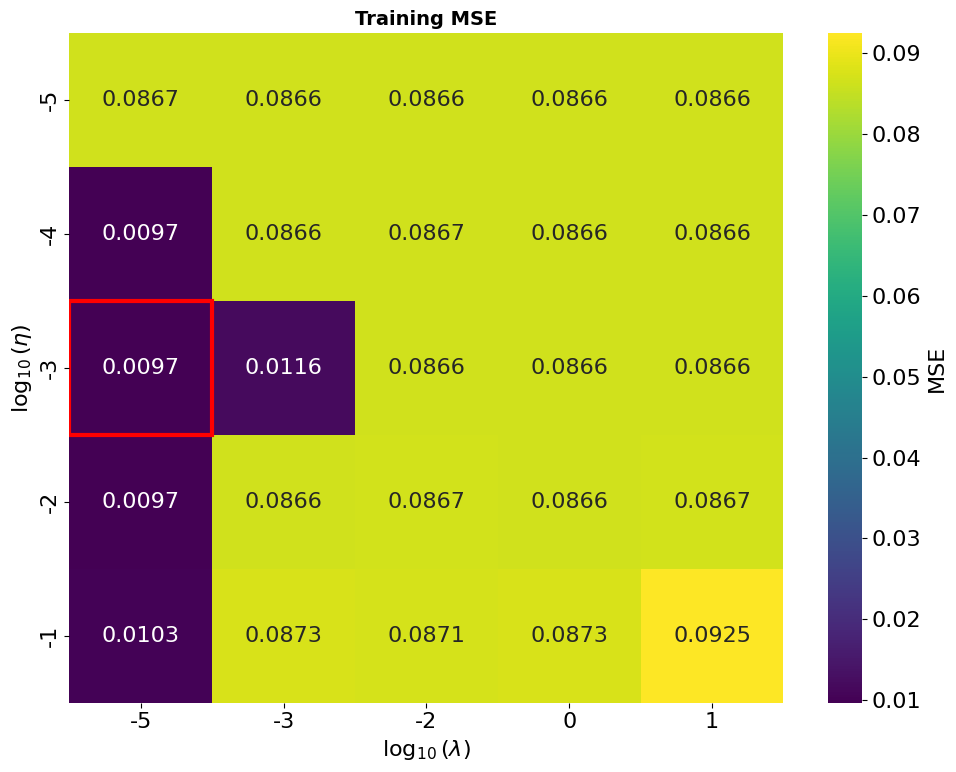

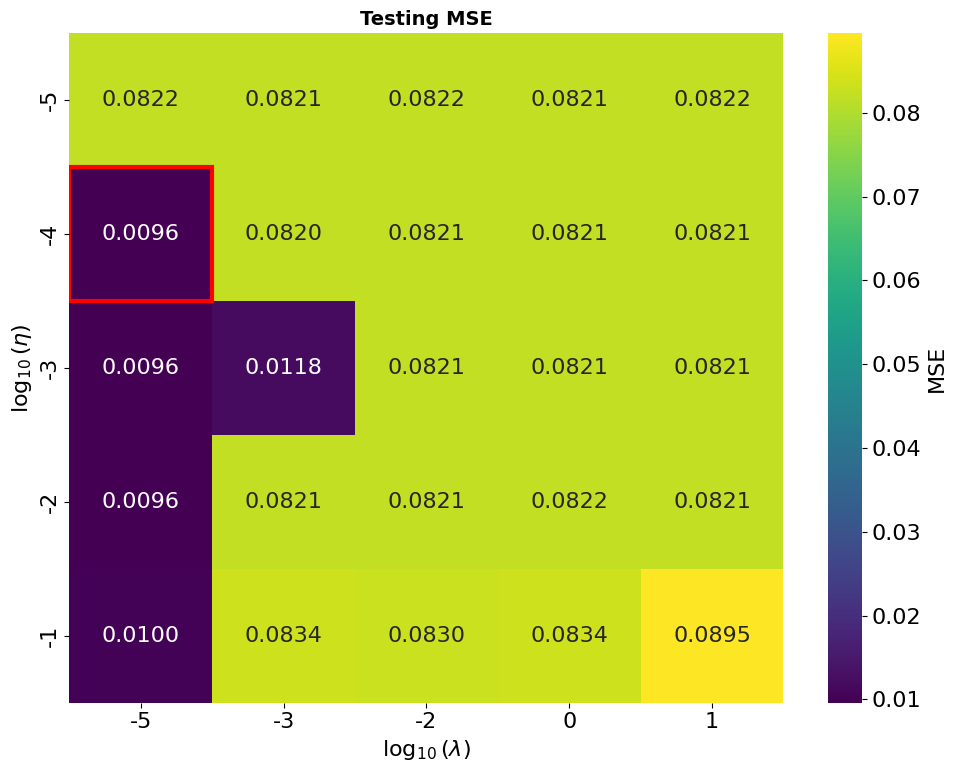

In [8]:
lambda_eta_heatmap(train_mse, eta_vals, lambda_vals, 
                   metric_name='MSE', dataset='Training')
plt.savefig(f"lambda_eta_heatmap_rms_train_{regularization_type_rms}.pdf")
plt.show()

lambda_eta_heatmap(test_mse, eta_vals, lambda_vals, 
                   metric_name='MSE', dataset='Testing')
plt.savefig(f"lambda_eta_heatmap_rms_test_{regularization_type_rms}.pdf")
plt.show()

# Stochastic Gradient Descent with Adam (L1/L2 Regularization)

In [ ]:
eta_vals = np.logspace(-5, -1, 5)
lambda_vals = np.logspace(-5, 1, 5)
hidden_layers = [50, 50]
regularization_type_adam = "l2"

n_eta = len(eta_vals)
n_lambda = len(lambda_vals)

# Storage
models = [[None for _ in range(n_lambda)] for _ in range(n_eta)]
train_mse = np.zeros((n_eta, n_lambda))
test_mse = np.zeros((n_eta, n_lambda))

# Grid search
for i, eta in enumerate(eta_vals):
    for j, lam in enumerate(lambda_vals):
        # Create and train model
        model = NeuralNetwork(
            network_input_size=1,
            layer_output_sizes=hidden_layers + [1],
            activations=[Sigmoid(), Sigmoid(), Linear()],
            loss=MSE(),
            seed=SEED,
            lambda_reg=lam,
            reg_type=regularization_type_adam if lam > 0 else None
        )
        
        optimizer = Adam(eta=eta)
        
        train(
            nn=model,
            X_train=X_train_s,
            y_train=y_train_s,
            X_val=X_test_s,
            y_val=y_test_s,
            optimizer=optimizer,
            epochs=500,
            batch_size=16,
            stochastic=True,
            task='regression',
            early_stopping=True,
            patience=50,
            verbose=False,
            seed=SEED
        )
        
        models[i][j] = model
        
        # Evaluate
        y_train_pred = inverse_scale_y(model.predict(X_train_s), y_mean)
        y_test_pred = inverse_scale_y(model.predict(X_test_s), y_mean)
        y_train_real = inverse_scale_y(y_train_s, y_mean)
        
        train_mse[i, j] = mse(y_train_real, y_train_pred)
        test_mse[i, j] = mse(y_test_real, y_test_pred)


min_idx_adam = np.unravel_index(np.argmin(test_mse), test_mse.shape)
i_best_adam, j_best_adam = min_idx_adam

best_eta_adam = eta_vals[i_best_adam]
best_lambda_adam = lambda_vals[j_best_adam]
best_test_mse_adam = test_mse[i_best_adam, j_best_adam]
best_train_mse_adam = train_mse[i_best_adam, j_best_adam]
print(f'Best eta:    {best_eta_adam}')
print(f'Best lambda: {best_lambda_adam}')
print(f'Best train MSE: {best_train_mse_adam}')
print(f'Best test MSE:  {best_test_mse_adam}')

Best eta:    0.1
Best lambda: 1e-05
Best train MSE: 0.009745704684904263
Best test MSE:  0.009697093959048417


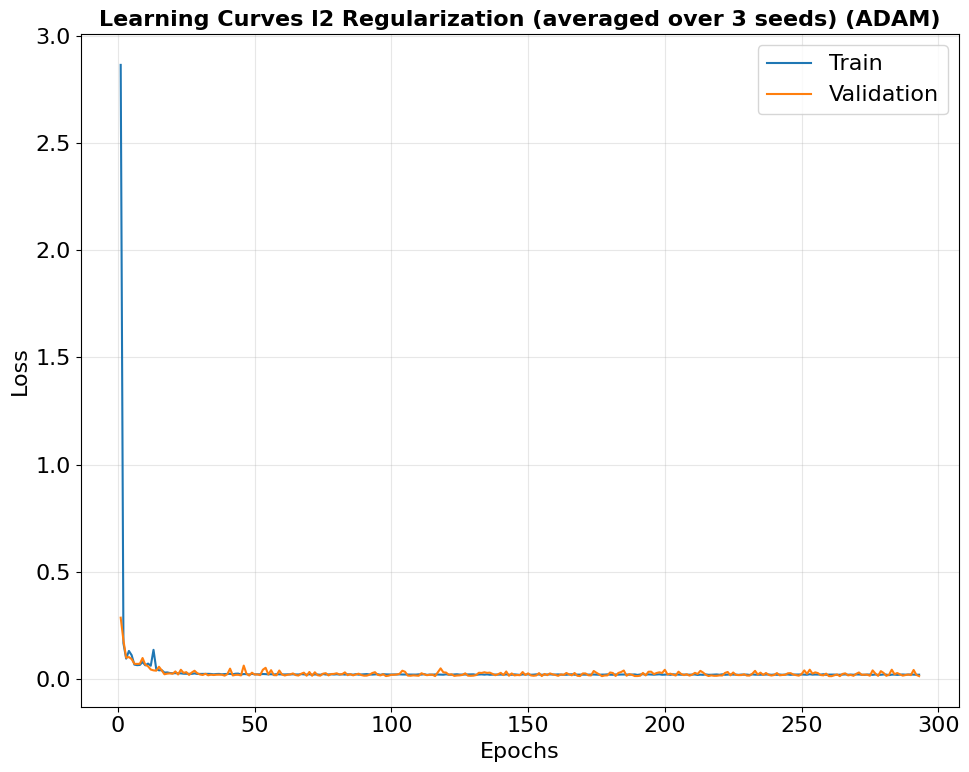

In [10]:
# --- Averaging over seeds using the fixed best hyperparameters ---
seeds = [100, 50, 12]
best_histories = []

for seed in seeds:
    model = NeuralNetwork(
        network_input_size=1,
        layer_output_sizes=hidden_layers + [1],
        activations=[Sigmoid(), Sigmoid(), Linear()],
        loss=MSE(),
        seed=seed,  # <-- use the loop seed
        lambda_reg=best_lambda_adam,
        reg_type=regularization_type_adam if best_lambda_adam > 0 else None,  # <-- use best_lambda
    )

    optimizer = RMSprop(eta=best_eta_adam)

    history = train(
        nn=model,
        X_train=X_train_s, y_train=y_train_s,
        X_val=X_val_s,     y_val=y_val_s,
        optimizer=optimizer,
        epochs=1500, batch_size=16, stochastic=True,
        task='regression',
        early_stopping=True, patience=150,
        verbose=False,
        seed=seed  # <-- use the loop seed
    )

    best_histories.append(history)

# Align (early stopping may yield different lengths)
min_len = min(len(h["train_loss"]) for h in best_histories)

train_mean = np.mean([np.array(h["train_loss"][:min_len]) for h in best_histories], axis=0)
val_mean   = np.mean([np.array(h["val_loss"][:min_len])   for h in best_histories], axis=0)

# Plot with your helper
plot_learning_curves(
    train_loss=train_mean,
    val_loss=val_mean,
    epochs=np.arange(1, min_len + 1),
    title=f"Learning Curves {regularization_type_adam} Regularization (averaged over 3 seeds) (ADAM)"
)
plt.savefig(f"figs/learning_curve_{regularization_type_adam}_adam.pdf")

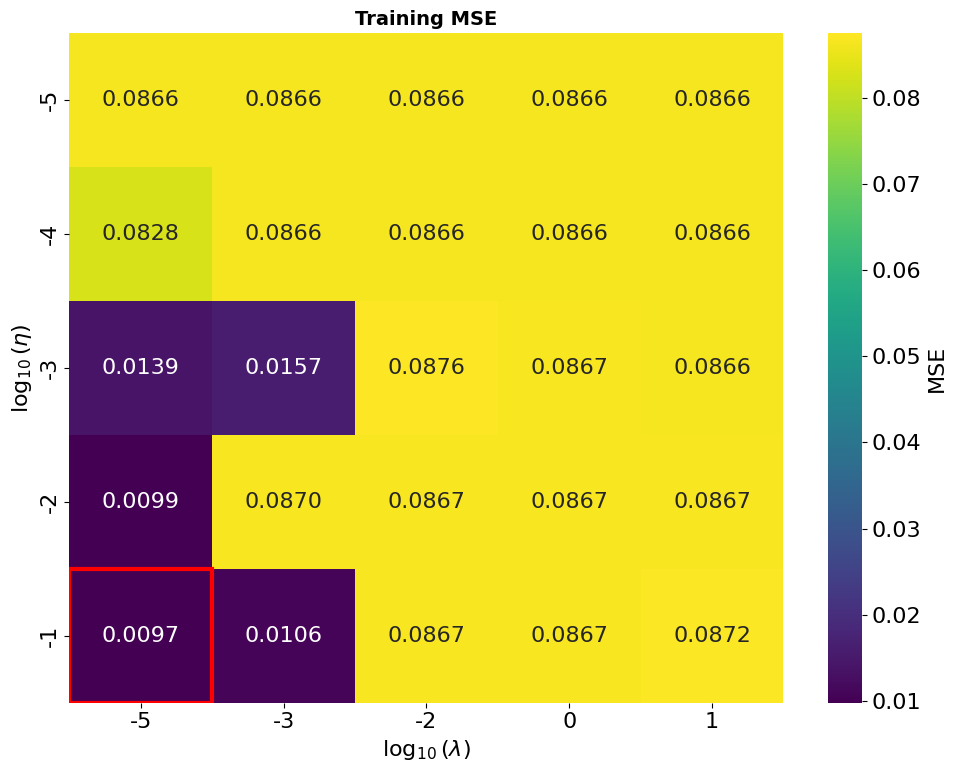

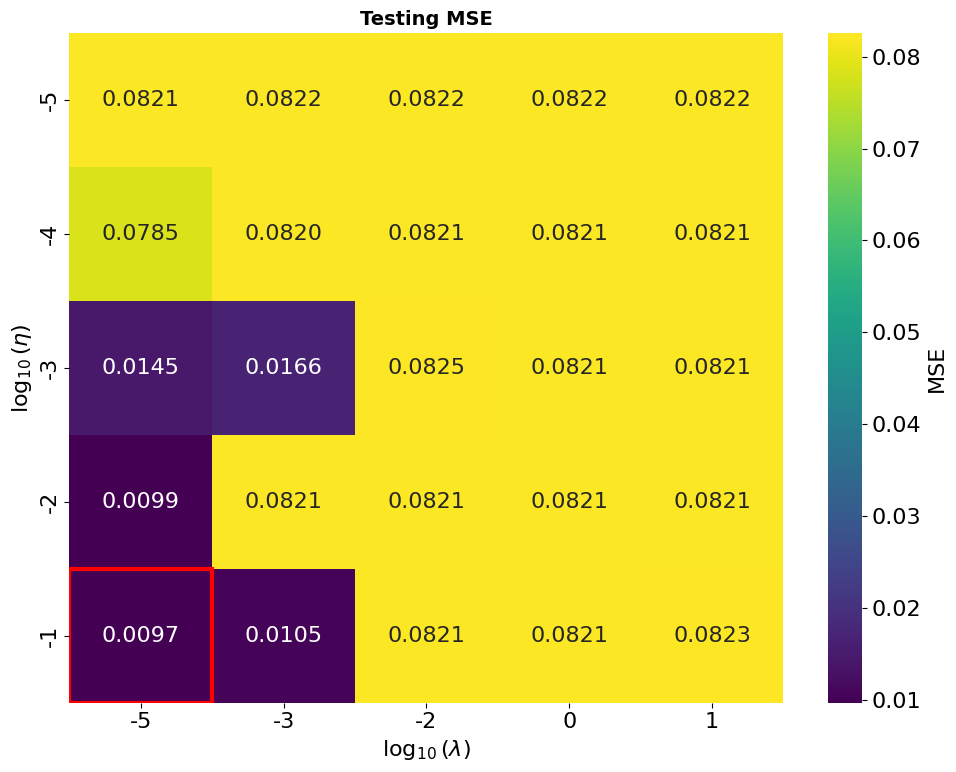

In [11]:
lambda_eta_heatmap(train_mse, eta_vals, lambda_vals, 
                   metric_name='MSE', dataset='Training')
plt.savefig(f"lambda_eta_heatmap_adam_train_{regularization_type_adam}.pdf")
plt.show()

lambda_eta_heatmap(test_mse, eta_vals, lambda_vals, 
                   metric_name='MSE', dataset='Testing')
plt.savefig(f"lambda_eta_heatmap_adam_test_{regularization_type_adam}.pdf")
plt.show()

# Comparing optimization algorithms, Ridge Regression and Lasso Regression

In [12]:
print("\n" + "="*50)
print("....")
print("="*50)
print(f"Ridge (deg 9):     {ridge_mse:.6f}")
print(f"Lasso (deg 9):     {lasso_mse:.6f}")
print(f"NN + RMSprop {regularization_type_rms}:      {best_test_mse_rms:.6f}   (eta={best_eta_rms:.4f})   (lambda={best_lambda_rms:.6f})")
print(f"NN + Adam {regularization_type_adam}:         {best_test_mse_adam:.6f}  (eta={best_eta_adam:.4f})  (lambda={best_lambda_adam:.6f})")
print("="*50)


....
Ridge (deg 9):     0.012380
Lasso (deg 9):     0.032906
NN + RMSprop l2:      0.009648   (eta=0.0100)   (lambda=0.000010)
NN + Adam l2:         0.009697  (eta=0.1000)  (lambda=0.000010)
